# Bryson reimplementation

Lets see how this works

In [1]:
import numpy as np

In [2]:

r_planet = 200000 # m
r_core = 100000 # m
dr = 1000 # m

temp_init = 1600 # K
temp_surface = 250 # K
temp_core_melting = 1200 # K

kappa = 5E-7 # m^2/s
kappa_reg = 5E-8 # m^2/s
reg_thikness = 8000 # m

core_density = 7800 # kg(^2??)/m^3
core_cp = 850 # J/kg/K
core_latent_heat = 270000 # J/kg
cmb_conductivity = 3.0 # W/m/K 

timestep = 2E11 # sec
max_time = 300 # Myr
max_time = max_time * 1000000 * 365 * 24 * 3600 #sec


In [3]:

radii = np.arange(r_core, r_planet+0.5*dr, dr)
core = np.arange(0, r_core-dr+0.5*dr, dr)

# Setup thermal diffusivity array, keeping track of regolith
kappas = np.ones_like(radii) * kappa
for i, r in enumerate(radii):
    d = r_planet - r
    if d < reg_thikness:
        kappas[i] = kappa_reg
        

In [4]:

# Set list of timesteps
times = np.arange(0, max_time+0.5*timestep, timestep)

# Big temperature array
temperatures = np.zeros((radii.size, times.size))

# Core temperature array
coretemp = np.zeros((core.size, times.size))


In [5]:

# initial temperautres and conditions

temperatures[:,0] = temp_init
temperature_core = temp_init
coretemp[:,0] = temp_init



max_core_lh = 4.0/3.0 * np.pi * r_core**3 * core_density * core_latent_heat
core_lh_extracted = 0.0

# Now we do the timestepping

i = 1
for i in range(1, len(times[1:])+1):
    t = times[i]
    for j in range(1, len(radii[1:-1])+1):
        r = radii[j]
        # eq 2 of Bryson SI
        temperatures[j, i] = (kappas[j] * timestep * (
            (1.0 / (radii[j] * dr))*(temperatures[j+1,i-1]-temperatures[j-1,i-1]) +
            (1.0 / dr**2) * (temperatures[j+1,i-1] - 2.0*temperatures[j,i-1] + temperatures[j-1, i-1]) )) \
            + temperatures[j, i-1]
            

    temperatures[-1,i] = temp_surface
    temperatures[0,i] = temperature_core
    coretemp[:,i] = temperatures[0,i]
    
    if (temperature_core > temp_core_melting) or (core_lh_extracted >= max_core_lh):
        # Cool the liquid or the solid
        temperature_core = temperature_core - (3*cmb_conductivity * ((temperatures[0,i]-temperatures[1,i])/dr) * timestep) \
                           / (core_density * core_cp * r_core)
    else:
        core_lh_extracted = core_lh_extracted + (4.0*np.pi*r_core**2) * cmb_conductivity * \
            ((temperatures[0,i]-temperatures[1,i])/dr) * timestep
            
    
            

In [6]:

import matplotlib.pyplot as plt
%matplotlib inline


/Users/andrew/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/andrew/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


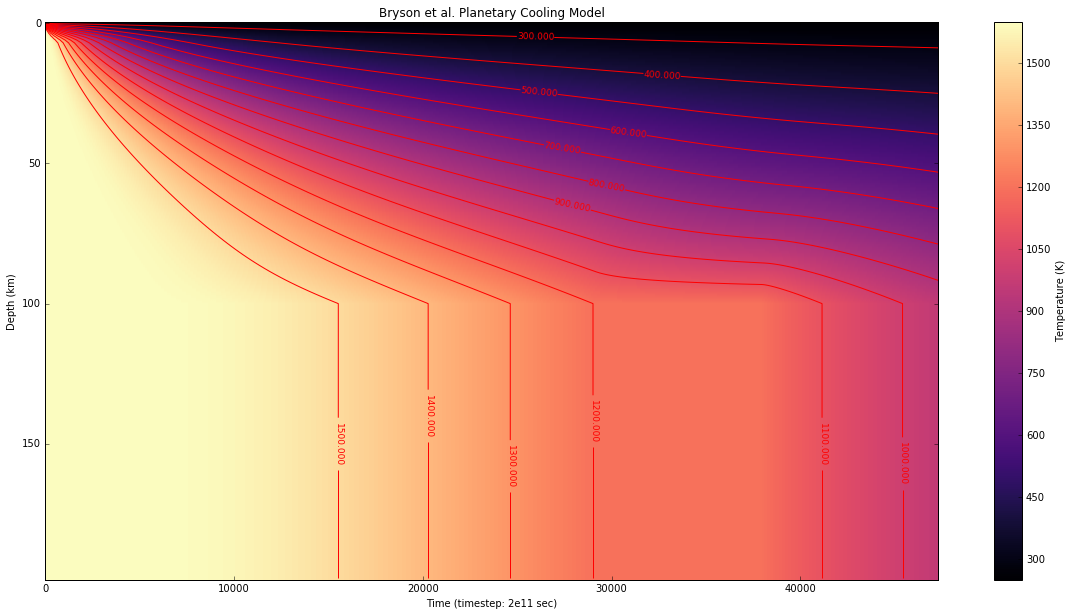

In [7]:

fig, ax = plt.subplots(figsize=(20,10))

im = ax.imshow(np.concatenate((temperatures[-1:0:-1,:],coretemp[-1:0:-1,:]),axis=0), aspect='auto', cmap='magma')


ax.set_xlabel("Time (timestep: 2e11 sec)")
ax.set_ylabel("Depth (km)")

levels = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]

cont = plt.contour(np.concatenate((temperatures[-1:0:-1,:],coretemp[-1:0:-1,:]),axis=0), levels, colors='r')

plt.clabel(cont, fontsize=9, inline=1)
plt.title('Bryson et al. Planetary Cooling Model')


cb = fig.colorbar(im)
cb.set_label('Temperature (K)')
